In [1]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

This model is re-created based on Garnett's paper:
https://journals.lww.com/stdjournal/Fulltext/2000/11000/Epidemiology_and_Control_of_Curable_Sexually.7.aspx

# 1. Define the components of all the sub-models
## 1.1 The births and deaths of Stock X

In [2]:
openX = Open( 
    (@stock_and_flow begin

        :stocks
        X

        :parameters
        μ

        :flows
        CLOUD => f_births(N * μ) => X
        X => f_deathX(X * μ) => CLOUD

        :sums
        N = [X]

        end 
    ),
    # feet
    foot(:X,:N,:X=>:N)
    
)

StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, SMulticospan{1, StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Cate

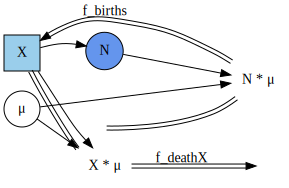

In [3]:
GraphF(apex(openX))

## 1.2 The SIS sub-model structure

In [28]:
openSIS_A = Open(
    (@stock_and_flow begin

        :stocks
        X
        A

        :parameters
        μ
        ϕ_complement
        σ′
        cβ

        :dynamic_variables
        v_inf₁ = cβ * NI
        v_inf₂ = v_inf₁ / N
        v_inf₃ = v_inf₂ * X
        v_inf₄ = v_inf₃ * ϕ_complement

        :flows
        X => f_newInfectiousA(v_inf₄) => A
        A => f_deathA(A * μ) => CLOUD
        A => f_recoveryA(A * σ′) => X

        :sums
        N = [X, A]
        NI = [A]

    end
    ),
     # feet
     foot(:X,:N,:X=>:N),
     foot((),:NI,())

)

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, Multicospan{StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAl

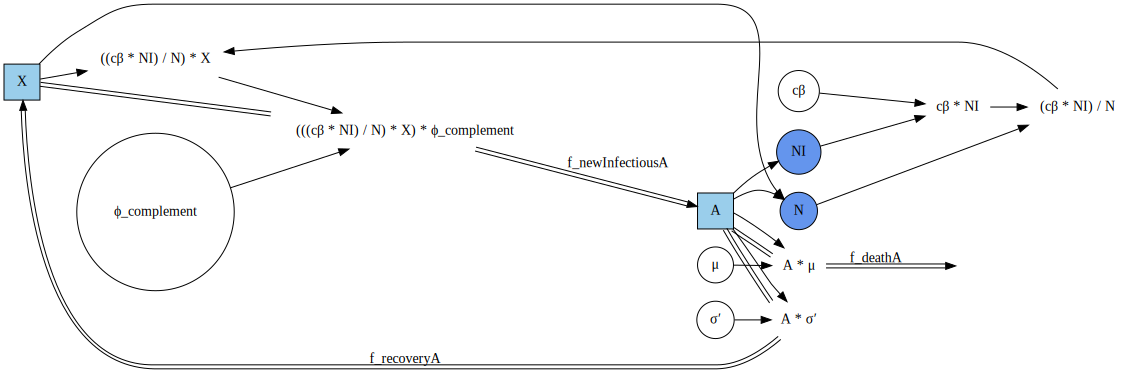

In [29]:
GraphF(apex(openSIS_A))

In [30]:
openSIS_Y = Open(
    (@stock_and_flow begin
    
    :stocks
    X
    Y

    :parameters
    μ
    ϕ
    σ
    cβ
    λ

    :dynamic_variables
    v_inf₄ = ϕ * λ # at present, lambda needs to come second
    # in algebraic rewriting, position of variables matters for homomorphisms.
    # When we later have *(ϕ), phi comes first

    :flows
    X => f_newInfectiousY(v_inf₄) => Y
    Y => f_deathY(Y * μ) => CLOUD
    Y => f_recoveryY(Y * σ) => X

    :sums
    N = [X, Y]
    NI = [Y]

end
        ),

     # feet
     foot(:X,:N,:X=>:N),
     foot((),:NI,())
    
)

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, Multicospan{StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAl

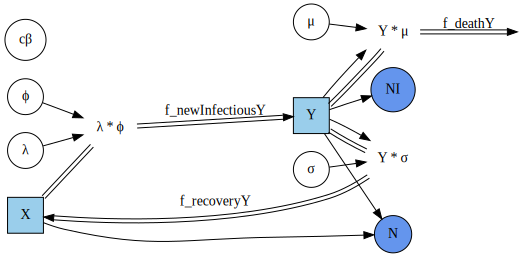

In [31]:
GraphF(apex(openSIS_Y))

# 2 Compose
## 2.1 Define composition rule

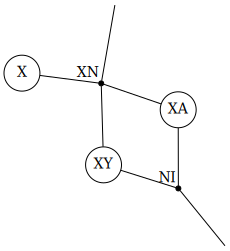

In [32]:
# define the UWD-algebra
uwd = @relation (XN,NI) begin
    X(XN)
    XA(XN,NI)
    XY(XN,NI)
end;
display_uwd(uwd)

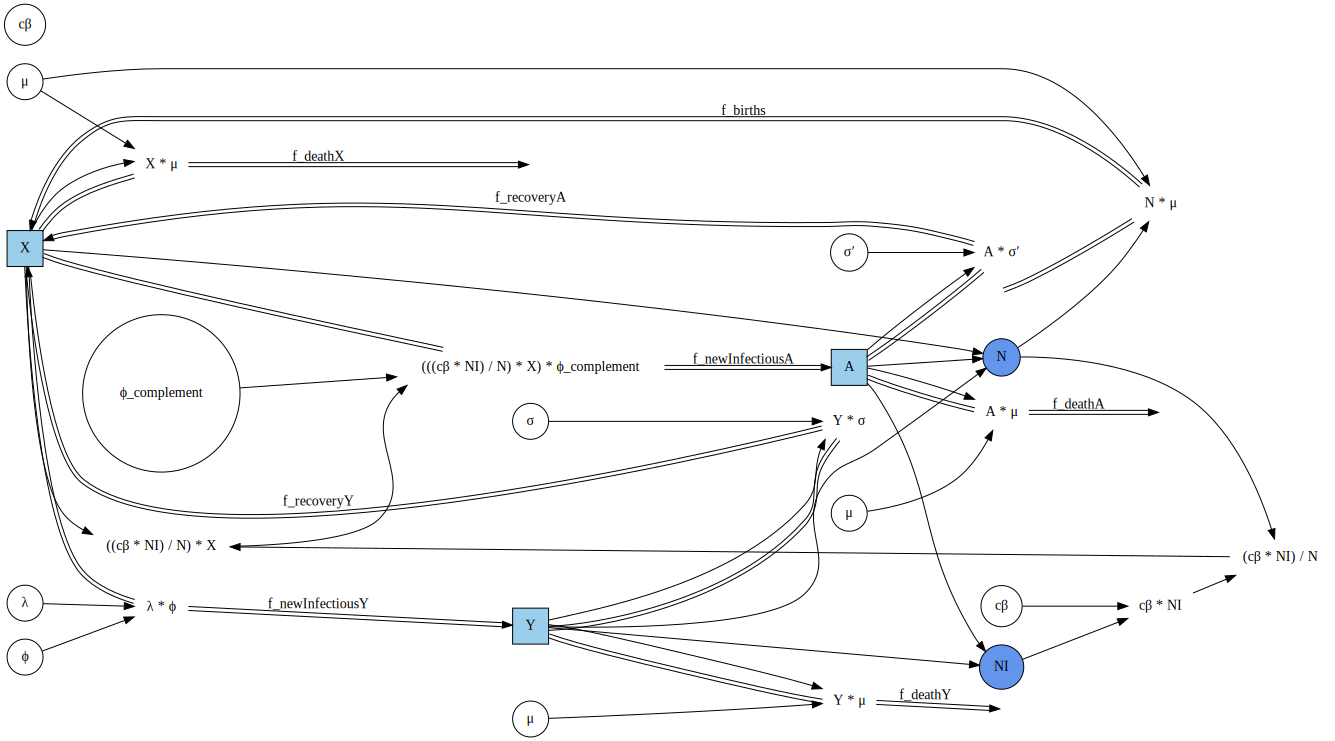

In [33]:
XAY_model = oapply(uwd,Dict(
    :X=>openX,
    :XA=>openSIS_A,
    :XY=>openSIS_Y
    )) |> apex
GraphF(XAY_model)

# 3 Rewrite

In [52]:
L = @stock_and_flow begin
    :stocks
    X
    Y

    :parameters
    λ
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = ϕ * λ

    :flows
    X => f_newInfectiousY(v_inf₄) => Y

    
    :sums
    N = [V, I]
    NI = [Y]
    end;
     


StockAndFlowF with elements S = 1:2, SV = 1:2, LS = 1:1, F = 1:1, I = 1:1, O = 1:1, V = 1:4, LV = 1:1, LSV = 1:2, P = 1:3, LVV = 1:2, LPV = 1:3
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     Y │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   2 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  4 │ f_newInfectiousY │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
└───┴─────┴────┘
┌───┬────────┬─────┐
│ V │  vname │ vop │
├───┼────────┼─────┤
│ 1 │ v_inf₁ │   * │
│ 2 │ v_inf₂ │   / │
│ 3 │ v_inf₃ │   * │
│ 4 │ v_inf₄ │   * │
└───┴────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   3 │           2 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     2 │    1 │             2 │
│   2 │     1 │    2 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     λ │
│ 2 │    cβ │
│ 3 │     ϕ │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             1 │
│   2 │     2 │     3 │             1 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    2 │    1 │            1 │
│   2 │    1 │    4 │            1 │
│   3 │    3 │    4 │            2 │
└─────┴──────┴──────┴──────────────┘

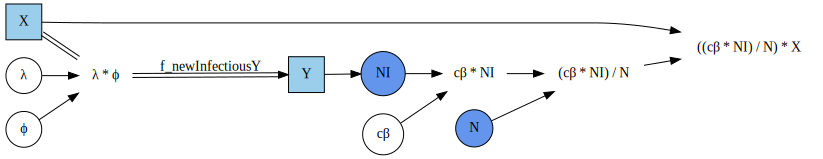

In [53]:
GraphF(L)

In [54]:
I = @stock_and_flow begin
    :stocks
    X
    Y

    :parameters
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = *(ϕ)

    :flows
    X => f_newInfectiousY(v_inf₄) => Y

    
    :sums
    N = [V, I]
    NI = [Y]
    end;
     


StockAndFlowF with elements S = 1:2, SV = 1:2, LS = 1:1, F = 1:1, I = 1:1, O = 1:1, V = 1:4, LV = 1:1, LSV = 1:2, P = 1:3, LVV = 1:2, LPV = 1:2
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     Y │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   2 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  4 │ f_newInfectiousY │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
└───┴─────┴────┘
┌───┬────────┬─────┐
│ V │  vname │ vop │
├───┼────────┼─────┤
│ 1 │ v_inf₁ │   * │
│ 2 │ v_inf₂ │   / │
│ 3 │ v_inf₃ │   * │
│ 4 │ v_inf₄ │   * │
└───┴────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   3 │           2 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     2 │    1 │             2 │
│   2 │     1 │    2 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     λ │
│ 2 │    cβ │
│ 3 │     ϕ │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             1 │
│   2 │     2 │     3 │             1 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    2 │    1 │            1 │
│   2 │    3 │    4 │            1 │
└─────┴──────┴──────┴──────────────┘

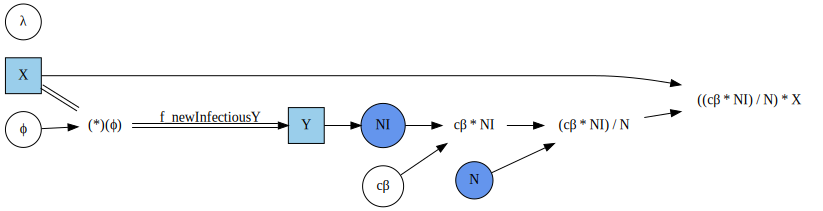

In [55]:
GraphF(I)

In [58]:
using AlgebraicRewriting
using AlgebraicRewriting: rewrite
const hom = AlgebraicRewriting.homomorphism

homomorphism (generic function with 3 methods)

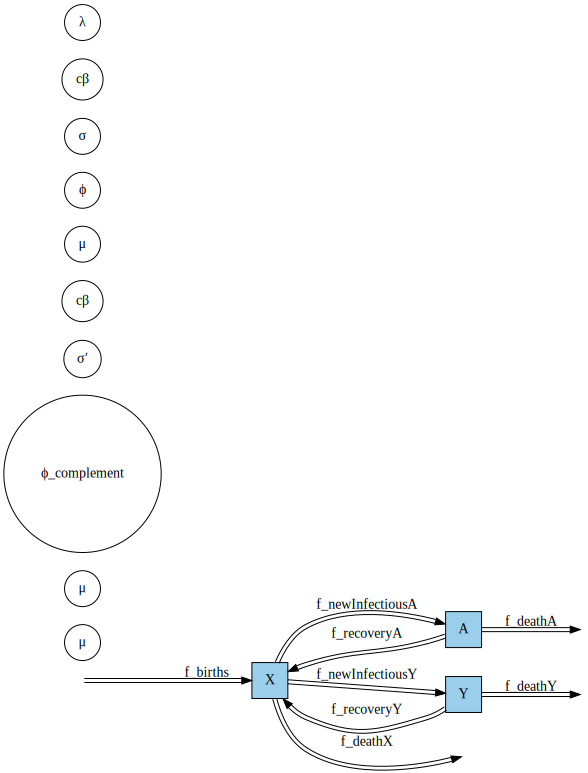

In [40]:
GraphF(XAY_model,type="SF")

# 3. Solve ODEs

In [41]:
# define values of constant parameters
# unit: year
p = LVector(
    cβ=15*0.7, μ=1/15,ϕ=(0.95+0.4)/2,σ=12/4,σ′=12/4,ϕ_complement=(1.0 - ((0.95+0.4)/2))
)
# define initial values for stocks
u0 = LVector(
    X=990, A=5, Y=5
)

3-element LArray{Int64, 1, Vector{Int64}, (:X, :A, :Y)}:
 :X => 990
 :A => 5
 :Y => 5

In [42]:
# results are tested the same as the Anylogic model
prob_XAY = ODEProblem(vectorfield(XAY_model),u0,(0.0,2.0),p);
sol = solve(prob_XAY,Tsit5(),abstol=1e-8);
plot(sol)

ErrorException: type LArray{Float64, 1, Vector{Float64}, (:cβ, :μ, :ϕ, :σ, :σ′, :ϕ_complement)} has no field λ

In [43]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")